# Week 14. Training Issues 2 (Review)

In this part, we would spend time revising common skills used in training model.

In short version, easy but useful.

In long version, we would introduce content in **Outline** step by step. 

We mainly reference from [sklearn](https://scikit-learn.org) and [Pytorch](https://pytorch.org)

Edited by Jiaxin Zhuang, Yang yang, Jiabin Cai.

# Outline

1. Common setup
    1. Commonly required module
    1. Random seed setting for reproducibility
1. Data split and Cross Validatioin
    1. Using sklearn's method to do Five-fold split
    2. Calculating Mean and Std for training dataset
    3. Data augmentation
2. classificatioon network 
    1. Original Resnet18
    2. Modified Resnet18 for out train dataset
3. Training 
    1. Including that define a model, loss function, metric, save model
    2. Pre-set hyper-parameters
    3. Initialize model parameters
    4. repeat over certain number of epochs
        1. Shuffle whole training data
        2. For each mini-batch data
            1. load mini-batch data
            2. compute gradient of loss over parameters
            3. update parameters with gradient descent
4. Transfer learning
5. Ensemble

In [ ]:
%load_ext autoreload
%autoreload 2

# 1.1 Commonly required module

[numpy](https://docs.scipy.org/doc/numpy-1.13.0/user/whatisnumpy.html): NumPy is the fundamental package for scientific computing in Python.

[pytorch](https://pytorch.org/docs/stable/index.html): End-to-end deep learning platform.

[torchvision](https://pytorch.org/docs/stable/torchvision/index.html): This package consists of popular datasets, model architectures, and common image transformations for computer vision.

[tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard): A suite of visualization tools to make training easier to understand, debug, and optimize TensorFlow programs.

[tensorboardX](https://tensorboardx.readthedocs.io/en/latest/tensorboard.html): Tensorboard for Pytorch.

In [ ]:
'''step 1'''
# Load all necessary modules here, for clearness
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import MNIST
import torchvision
from torchvision import transforms
from torch.optim import lr_scheduler
# from tensorboardX import SummaryWriter
from collections import OrderedDict
from matplotlib import pyplot as plt

In [ ]:
'''step 2'''
# Whether to put data in GPU according to GPU is available or not 
# cuda = torch.cuda.is_available() 
#  In case the default gpu does not have enough space, you can choose which device to use
# torch.cuda.set_device(device) # device: id

# Since gpu in lab is not enough for your guys, we prefer to cpu computation
device = torch.device("cuda:2") 

# 1.2 Random seed setting for reproducibility
In order to make computations deterministic on your specific problem on one specific platform and PyTorch release, there are a couple of steps to take.

In [ ]:
'''step 3'''
# However, in the same exp, seed for torch and numpy doesn't be the same.
SEED = 47

# Sets the seed for generating random numbers, including GPU and CPU
torch.manual_seed(SEED)

# Deterministic algorithm for convolutional ops
torch.backends.cudnn.deterministic = True
# Deterministic alogorithm for cudnn, otherwise, cuddn would choose the fastest algorithm for every 
# iteration ops, which cause variability and time consuming if input changes frequently.
torch.backends.cudnn.benchmark = False

# Seed the generator for Numpy
np.random.seed(SEED)

# 2. Data split and Cross Validatioin
We would split **Cifar10** into 5-fold and do cross validation.

The Cifar10 database (Modified National Institute of Standards and Technology database) s a collection of images that are commonly used to train machine learning and computer vision algorithms.

The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class

And they look like images below.

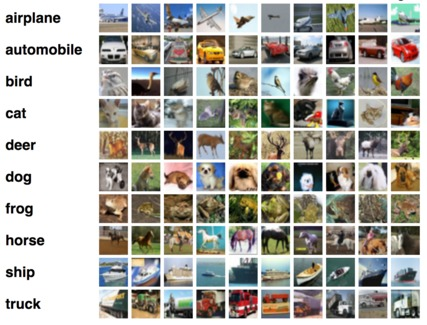

## 2.1 Using sklearn's method to do Five-fold split

TODO

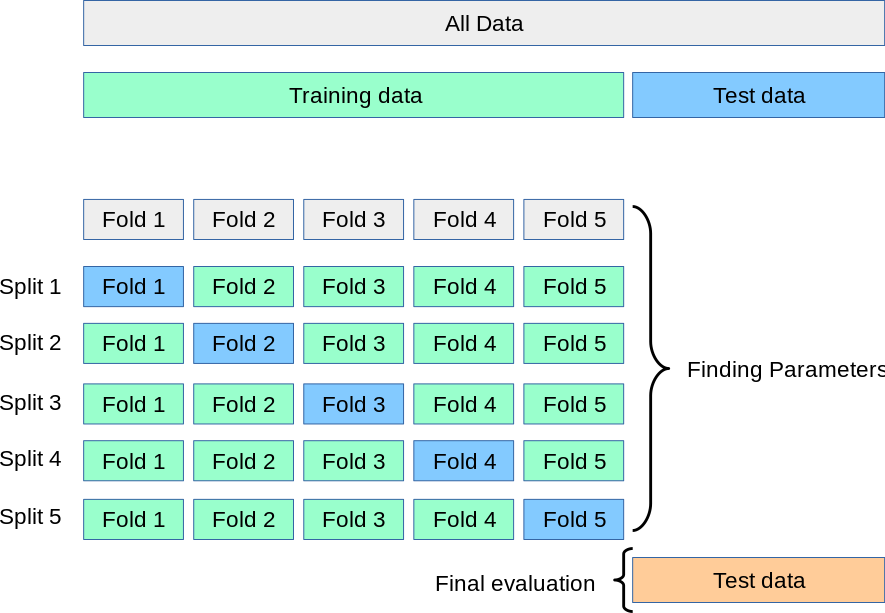

In [ ]:
# Example to use kFold
from sklearn.model_selection import KFold
import numpy as np

train_transform = transforms.Compose([
    
])

dataset = torchvision.datasets.CIFAR10(root='./data',
                                      train=True, transform=train_transform,download=True)

data = dataset.train_data

# dataset.train_labels gets list object, we should transform to numpy for convinience
label = np.array(dataset.train_labels)

# set numpy random seed, we can get a determinate k-fold dataset
# np.random.seed(1)

kf = KFold(n_splits=5,shuffle=True)

for train_index, test_index in kf.split(data):
    print('train_index', train_index, 'test_index', test_index)
    train_data, train_label = data[train_index], label[train_index]
    test_data, test_label = data[test_index], label[test_index]

# here we use the last fold to be our trainset
dataset.train_data = train_data
dataset.train_labels = list(train_label)

# 2.2 Calculating Mean and Std for training dataset

In [ ]:
def get_mean_std(dataset, ratio=0.01):
    """Get mean and std by sample ratio
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), 
                                             shuffle=True, num_workers=10)
    train = iter(dataloader).next()[0]
    mean = np.mean(train.numpy(), axis=(0,2,3))
    std = np.std(train.numpy(), axis=(0,2,3))
    return mean, std

In [ ]:
# cifar10
train_dataset = torchvision.datasets.CIFAR10('./data', 
                                             train=True, download=False, 
                                             transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10('./data', 
                                           train=False, download=False, 
                                            transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)

test_mean, test_std = get_mean_std(test_dataset)

print(train_mean, train_std)
print(test_mean,test_std)

## 2.3 Hyper parameter

In [ ]:
'''step 4'''
# set hyper parameter 
batch_size = 32
n_epochs = 50
learning_rate = 1e-3

## 2.4 Data augmentation

Using suitable data augmentation usually can get a better model. However, not all augmentation function are effective to all dataset It is advisable to choose favorable function for our dataset.  
transform document:[https://pytorch.org/docs/stable/torchvision/transforms.html]  

here are the most commonly used functions you may interest  


- torchvision.transforms.Compose()  
- torchvision.transforms.CenterCrop()
- torchvision.transforms.Pad()
- torchvision.transforms.RandomCrop()
- torchvision.transforms.RandomHorizontalFlip()
- torchvision.transforms.Resize()
- torchvision.transforms.Normalize()
- torchvision.transforms.ToPILImage()
- torchvision.transforms.ToTensor()
- torchvision.transforms.RandomRotation()

There is not standard answer for how to choose a suitable augmentation for your dataset, but we try to teach you what may be useful.  

We use cifar10 as our dataset in this class. so, here are some suggestion when you use it.  

The size of images in cifar10 are 32×32, it maybe not suitable to choose **rotation operation** for the images, becuase rotation will bring black pixels, those black pixels may exist after **randomcrop operation**.

we suggest that you can consider to use horizontal flip in nature dataset but not use vertical flip. becuase you know it is very rare for an object to be inverted.

In [ ]:
%matplotlib inline
from PIL import Image

# rotate 30°
transform_rotate = transforms.RandomRotation((30,30))

transform_horizontalflip = transforms.RandomHorizontalFlip(p=1)

transform_verticalflip = transforms.RandomVerticalFlip(p=1)


In [ ]:
# the first image in cifar10 trainset
img = Image.open('./img/example.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# a cat image
img1 = Image.open('./img/cat.jpeg')
plt.imshow(img1)
plt.axis('off')
plt.show()

In [ ]:
# rotate the image
img2 = transform_rotate(img1)
plt.imshow(img2)
plt.axis('off')
plt.show()

In [ ]:
# horizontal flip the image
img3 = transform_horizontalflip(img1)
plt.imshow(img3)
plt.axis('off')
plt.show()

In [ ]:
# vertical flip the image
img4 = transform_verticalflip(img1)
plt.imshow(img4)
plt.axis('off')
plt.show()

In [ ]:
'''step 5'''
'''
    the mean and variance below are from get_mean_std() function, every time you run the above function may get
    defferent value, because we use sampling
'''

'''
    notice: we usually will not use the dataset above, because its transform function has been change the numpy
    data to tensor data, but those transformations such as filp, rotation, crop, pad should be done before the
    data transforms to tensor.
'''

# transform1
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
    transforms.ToTensor(), # Convert a PIL Image or numpy.ndarray to tensor.
    # Normalize a tensor image with mean 0.1307 and standard deviation 0.3081
    transforms.Normalize((0.4931373, 0.48048604, 0.44251624), (0.24307655, 0.23882599, 0.25874203))
])

# transform2
# train_transform = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.48723358, 0.48176482, 0.45129994), (0.24020454, 0.23832673, 0.25824794))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                            train=True, 
                            transform=train_transform,
                            download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                           train=False, 
                           transform=test_transform,
                           download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# 3. classificatioon network

## 3.1 Original Original Resnet18

In [ ]:
resnet18 = torchvision.models.resnet18()
print(resnet18)

## 3.2 Modified Resnet18 for out train dataset

As we can see, the resnet model we import from **torchvison.models** downsamples five times, It means that the size of feature maps in avgpooling layer is only 1×1, we may lose too much information during the convolution layers. It's worth noting that before enter the blocks, the input images have been downsapled tow times, we lose lots of information. so, fixing the first two downsaple layer may be a good choise.

In [ ]:
'''step 6'''
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18,self).__init__()
        original_model = torchvision.models.resnet18()
        original_model.conv1.stride = 1
        self.feature_extractor = nn.Sequential(
            *(list(original_model.children())[0:3]),
            *(list(original_model.children())[4:-2]),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(512,10)
        
    def forward(self, x):
        out1 = self.feature_extractor(x)
        out1 = out1.view(out1.size(0),-1)
        out2 = self.fc(out1)
        return out2

# 4. Training 
We would define training function here. Additionally, hyper-parameters, loss function, metric would be included here too. 

## 4.1 Pre-set hyper-parameters
setting hyperparameters like below

hyper paprameters include following part

* learning rate: usually we start from a quite bigger lr like 1e-1, 1e-2, 1e-3, and slow lr as epoch moves.
* n_epochs: training epoch must set large so model has enough time to converge. Usually, we will set a quite big epoch at the first training time.  
* batch_size: usually, bigger batch size mean's better usage of GPU and model would need less epoches to converge. And the exponent of 2 is used, eg. 2, 4, 8, 16, 32, 64, 128. 256.  

In [ ]:
'''step 7'''
# create a model object
# model = torchvision.models.resnet18()
# model.avgpool = nn.AdaptiveAvgPool2d(1)
# model.fc = nn.Linear(512,10)
model = ResNet18()
model.to(device)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 

## 4.2 Initialize model parameters
Pytorch provide default initialization (**uniform intialization**) for linear layer. But there is still some useful intialization method.

Read more about initialization from this [link](https://pytorch.org/docs/stable/_modules/torch/nn/init.html)

```
    torch.nn.init.normal_
    torch.nn.init.uniform_
    torch.nn.init.constant_
    torch.nn.init.eye_
    torch.nn.init.xavier_uniform_
    torch.nn.init.xavier_normal_
    torch.nn.init.kaiming_uniform_
```

## 4.3 Repeat over certain numbers of epoch

* Shuffle whole training data 

```shuffle
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
```
* For each mini-batch data

    * load mini-batch data
    
    ```
    for batch_idx, (data, target) in enumerate(train_loader): \
        ...
    ```
    
    * compute gradient of loss over parameters
    
    ```
     output = net(data) # make prediction
     loss = loss_fn(output, target)  # compute loss 
     loss.backward() # compute gradient of loss over parameters 
    ```
    
    * update parameters with gradient descent
    
    ```
    optimzer.step() # update parameters with gradient descent 
    ```


In [ ]:
'''step 8'''
def train(train_loader, model, loss_fn, optimizer,device):
    """train model using loss_fn and optimizer. When thid function is called, model trains for one epoch.
    Args:
        train_loader: train data
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
        optimizer: optimize the loss function
    Returns:
        total_loss: loss
    """
    
    # set the module in training model, affecting module e.g., Dropout, BatchNorm, etc.
    model.train()
    
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # clear gradients of all optimized torch.Tensors'
        outputs = model(data) # make predictions 
        loss = loss_fn(outputs, target) # compute loss 
        total_loss += loss.item() # accumulate every batch loss in a epoch
        loss.backward() # compute gradient of loss over parameters 
            
        optimizer.step() # update parameters with gradient descent 
            
    average_loss = total_loss / batch_idx # average loss in this epoch
    
    return average_loss

In [ ]:
'''step 9'''
def evaluate(loader, model, loss_fn, device):
    """test model's prediction performance on loader.  
    When thid function is called, model is evaluated.
    Args:
        loader: data for evaluation
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
    Returns:
        total_loss
        accuracy
    """
    
    # context-manager that disabled gradient computation
    with torch.no_grad():
        
        # set the module in evaluation mode
        model.eval()
        
        correct = 0.0 # account correct amount of data
        total_loss = 0  # account loss
        
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data) # make predictions 
            # return the maximum value of each row of the input tensor in the 
            # given dimension dim, the second return vale is the index location
            # of each maxium value found(argmax)
            _, predicted = torch.max(outputs, 1)
            # Detach: Returns a new Tensor, detached from the current graph.
            #The result will never require gradient.
            correct += (predicted == target).cpu().sum().detach().numpy()
            loss = loss_fn(outputs, target)  # compute loss 
            total_loss += loss.item() # accumulate every batch loss in a epoch
        
        accuracy = correct*100.0 / len(loader.dataset) # accuracy in a epoch
        average_loss = total_loss / len(loader)
        
    return average_loss, accuracy

Define function fit and use train_epoch and test_epoch

In this section we will produce tow method to change learning rate during the period of training  

- use **optimizer.param_groups** to change the learning rate in the optimizer at any epoch you want

- use **optimizer.lr_scheduler.StepLR()** to change the learning rate in the optimizer every several of epoch


when you find training loss and accuracy tend to be gentle, it maybe usful to decay the learning rate, but it is not always effective, you should do more experience to choose a suitable hyper parameters for your model

In [ ]:
'''step 10'''
def fit(train_loader, val_loader, model, loss_fn, optimizer, n_epochs, device):
    """train and val model here, we use train_epoch to train model and 
    val_epoch to val model prediction performance
    Args: 
        train_loader: train data
        val_loader: validation data
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
        optimizer: optimize the loss function
        n_epochs: training epochs
    Returns:
        train_accs: accuracy of train n_epochs, a list
        train_losses: loss of n_epochs, a list
    """
    
    
    train_accs = [] # save train accuracy every epoch
    train_losses = [] # save train loss every epoch
    
    test_accs = []
    test_losses = []
    
#     scheduler = lr_scheduler.StepLR(optimizer,step_size=6,gamma=0.1)
    
    for epoch in range(n_epochs): # train for n_epochs 
        # train model on training datasets, optimize loss function and update model parameters
        
        # change the learning rate at any epoch you want 
#         if n_epochs % 6 == 0 and n_epochs != 0:
#             lr = lr * 0.1
#             for param_group in optimizer.param_groups:
#                 param_groups['lr'] = lr
        
        train_loss= train(train_loader, model, loss_fn, optimizer, device=device)
        
        # evaluate model performance on train dataset
        _, train_accuracy = evaluate(train_loader, model, loss_fn, device=device)
        
        # change the learning rate by scheduler
#         scheduler.step()
        
        
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                n_epochs, train_loss, train_accuracy)
        print(message)
    
        # save loss, accuracy
        train_accs.append(train_accuracy)
        train_losses.append(train_loss)
        show_curve(train_accs,'tranin_accs')
        show_curve(train_losses,'train_losses')
    
        # evaluate model performance on val dataset
        val_loss, val_accuracy = evaluate(val_loader, model, loss_fn, device=device)
        
        
        test_accs.append(val_accuracy)
        test_losses.append(val_loss)
        show_curve(test_accs,'test_accs')
        show_curve(test_losses,'test_losses')
        
        
        message = 'Epoch: {}/{}. Validation set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                n_epochs, val_loss, val_accuracy)
        print(message)
            
    return train_accs, train_losses

In [ ]:
'''step 10'''
def show_curve(ys, title):
    """plot curlve for Loss and Accuacy
    
    !!YOU CAN READ THIS LATER, if you are interested
    
    Args:
        ys: loss or acc list
        title: Loss or Accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

In [ ]:
'''step 12'''
train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, device=device)

If you want design a model, in its convolution layers, the original learning rate is 0.1, while the original learning rate of linear layer is 0.01, and you want to nine times smaller its learning rate every 10 epoch. Please write down your solution by pseudo code.

### 4.4 save model 
Pytorch provide two kinds of method to save model. We recommmend the method which only saves parameters. Because it's more feasible and dont' rely on fixed model. 

When saving parameters, we not only save **learnable parameters in model**, but also **learnable parameters in optimizer**. 

A common PyTorch convention is to save models using either a .pt or .pth file extension.

Read more abount save load from this [link](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

Generally speaking, to save our disk space and training time, we usually save the best model in Verification set and the last model for the last epoch.

the next cell will show you how to save the parameters of model and models.

In [ ]:
# to save the parameters of a model
torch.save(model.state_dict(), './params/resnet18_params.pt')

# to save the model
torch.save(model, './params/resnet18.pt')

You can get your the performance of your model at test set in every epoch. so, you can save the best model during the training period. Please add this function into your **train()** function

# 5. Transfer Learning

In this section, you will learn how to load the parameters you trained to your new model

In [ ]:
model1 = torchvision.models.resnet18()
print(model1.state_dict())

# generate a parameters file of model1
torch.save(model1.state_dict(),'./params/resnet18_params.pt')

In [ ]:
model2 = torchvision.models.resnet18()
model2.fc = nn.Linear(512,10)

Now, we want to load model1's parameters to model2, however, they have different structure, we can't simply use **model2.load()** or **model2.load_state_dict()**. we should load part of the parameters of the model1 to model2. For examlpe, if we want to load the convolution layers parameters, we can do like below.

In [ ]:
'''
    parameters are saved as dict in .pt file, so, we should get its keys first.
'''
print(model2.state_dict().keys())

We can see the last layer of convolution is **'layer4.1.bn2.num_batches_tracked'**. Now, let's load it to our new model.

In [ ]:
pretrained_params = torch.load('./params/resnet18_params.pt')
model2_params = model2.state_dict()
for (pretrained_key,pretrained_val), (model2_key,model2_val) in zip(list(pretrained_params.items()),list(model2_params.items())):
    model2_params[model2_key] = pretrained_val
    if model2_key == 'layer4.1.bn2.num_batches_tracked':
        break

# don't forget to load parametes dict to your model!!!
model2.load_state_dict(model2_params)

print(model1.state_dict())

In [ ]:
print(model2.state_dict())

# 6. Emsemble

when you trained your model for several times, you can emsemble those models to predict test set.
for example, if you trained three models using the same train set, when a new image arrivied, it will be sent to those models and get three predictions, you can design a voting mechanism to improve the performance of your model.

# class work
please use training skills to train a better resnet model on cifar10, you can change hyper parameters and transforms as you wish, please show your final best accuracy in this page.


In [ ]:
n_epochs = 50
learning_rate = 0.005

model = ResNet18()
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, device=device)